In [ ]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving git_emotion.ipynb to git_emotion.ipynb
User uploaded file "git_emotion.ipynb" with length 8227 bytes


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!ls

AccVal_acc1.png     emotion1.ipynb			 LossVal_loss.png
AccVal_acc.png	    Emotion_little_vgg.h5		 photo.jpg
archive.zip	    git_emotion.ipynb			 tt_data
capture_face.ipynb  haarcascade_frontalface_default.xml
cnn_model.h5	    LossVal_loss1.png


In [ ]:
%cd /content/drive/MyDrive/EBMRS/

/content/drive/MyDrive/EBMRS


In [ ]:
!ls

AccVal_acc1.png  emotion1.ipynb			      LossVal_loss.png
AccVal_acc.png	 Emotion_little_vgg.h5		      photo.jpg
archive.zip	 haarcascade_frontalface_default.xml  tt_data
cnn_model.h5	 LossVal_loss1.png


In [ ]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# Labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# load model and classifier
# classifier =load_model('Emotion_little_vgg.h5')
classifier =load_model('cnn_model.h5')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg


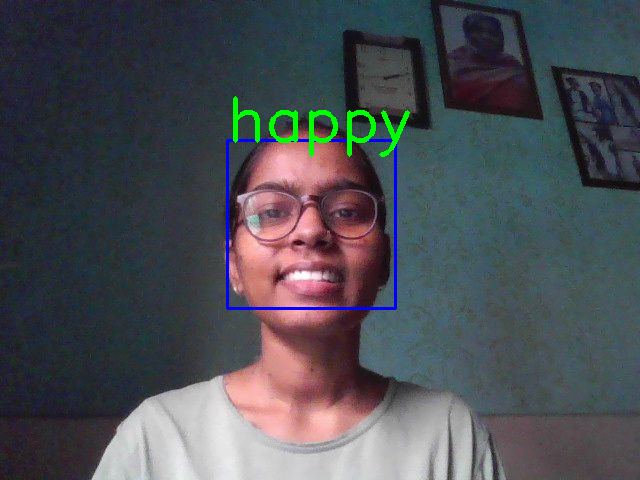

In [ ]:
from google.colab.patches import cv2_imshow

# read image and convert in grayscale
frame = cv2.imread('photo.jpg')
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.3,5)

for (x,y,w,h) in faces:
  cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
  roi_gray = gray[y:y+h,x:x+w]
  roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)
  
if np.sum([roi_gray])!=0:
  roi = roi_gray.astype('float')/255.0
  roi = img_to_array(roi)
  roi = np.expand_dims(roi,axis=0)

  preds = classifier.predict(roi)[0]
  label=class_labels[preds.argmax()]
  label_position = (x,y)
  cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
else:
  cv2.putText(frame,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
cv2_imshow(frame)